This code includes the exploratory analysis of the data for the cleaned dataset, used to create the second section of the data appendix.

Total observations (rows): 6574
Total variables (columns): 10

Missingness (sorted by % missing):
          variable  total_observations  non_null  nulls  pct_missing
0          Country                6574      6574      0          0.0
1      Review Text                6574      6574      0          0.0
2      year_posted                6574      6574      0          0.0
3     month_posted                6574      6574      0          0.0
4         month_ex                6574      6574      0          0.0
5          year_ex                6574      6574      0          0.0
6     review count                6574      6574      0          0.0
7           rating                6574      6574      0          0.0
8    rating_binary                6574      6574      0          0.0
9  Country_grouped                6574      6574      0          0.0

Quantitative variables: ['year_posted', 'month_posted', 'review count', 'rating', 'rating_binary']
Categorical variables: ['Country', 'month_e

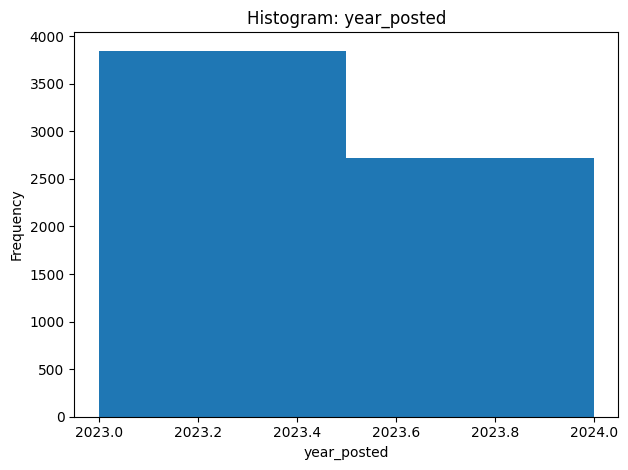

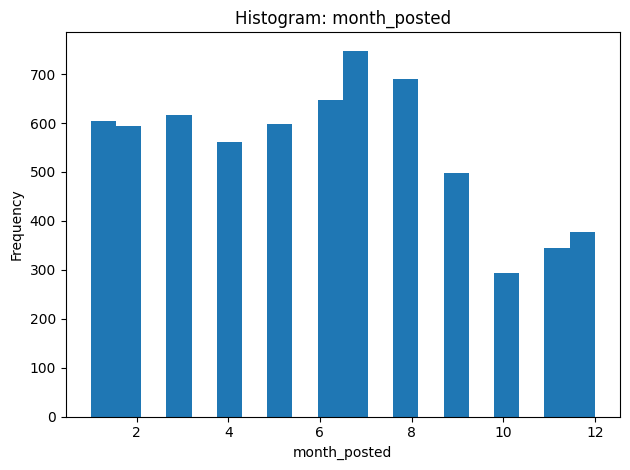

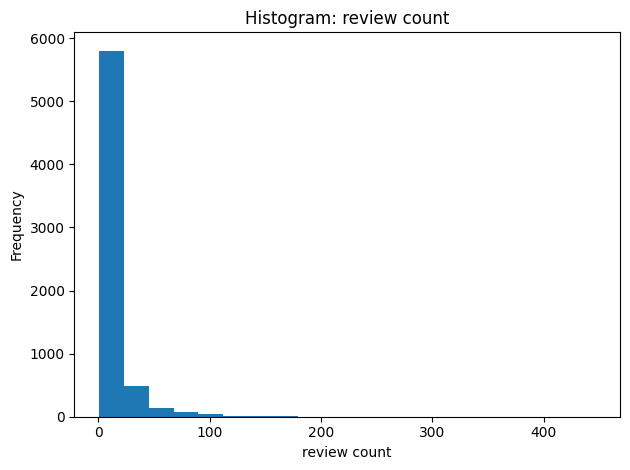

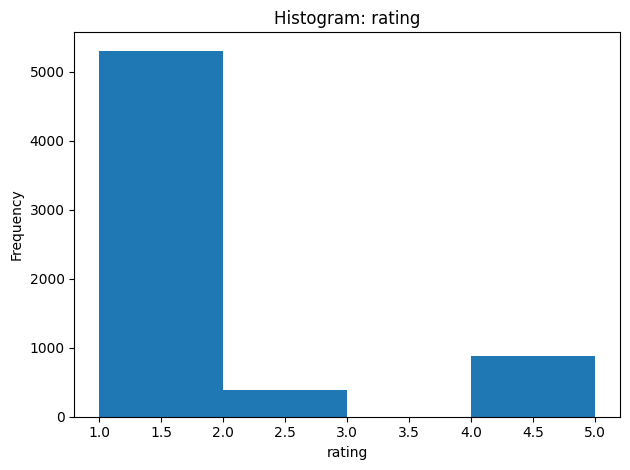

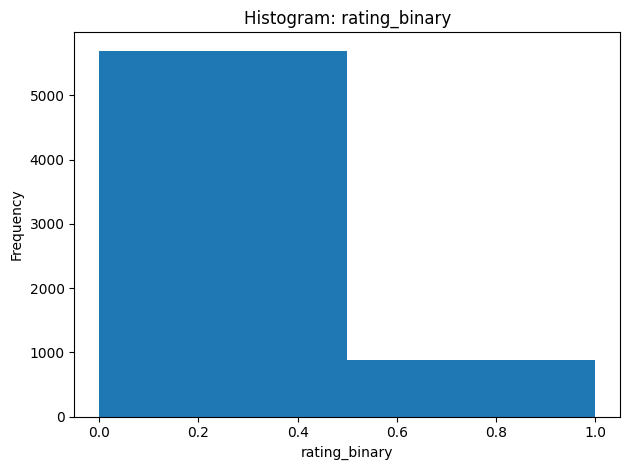

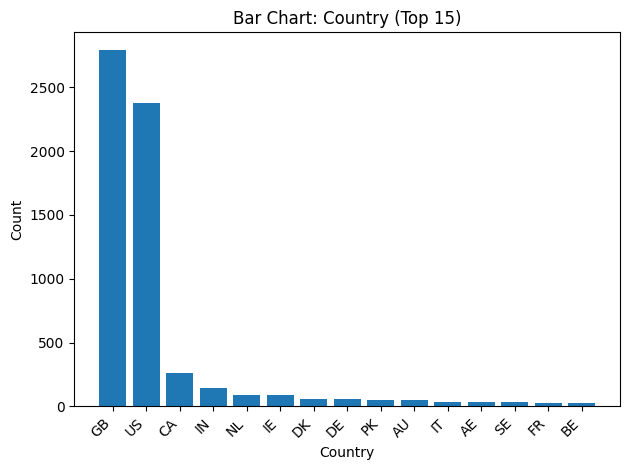

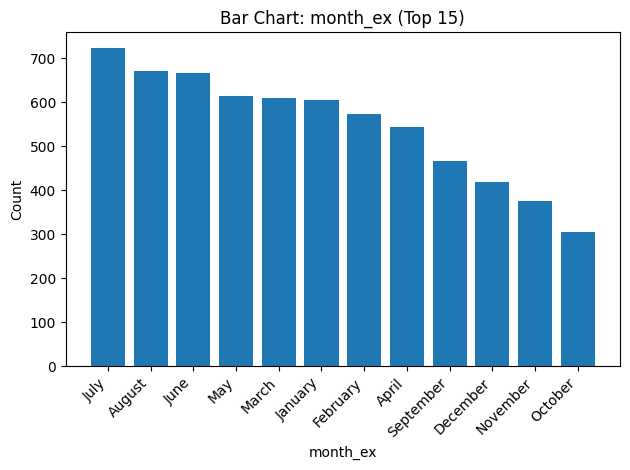

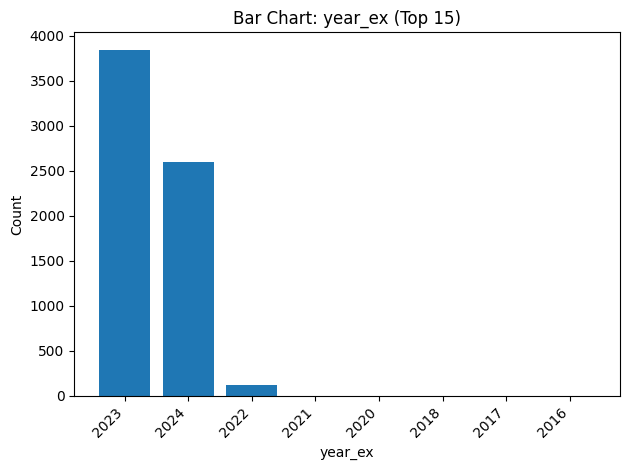

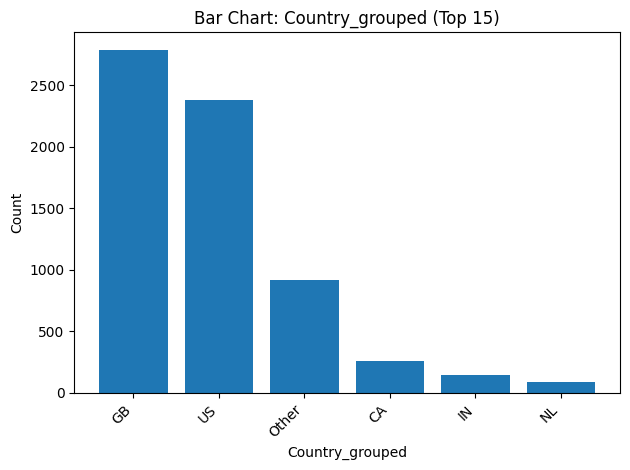


Saved Data Appendix outputs to: DataAppendixOutput/


In [11]:
import pandas as pd
df = pd.read_csv(
    "Amazon_Reviews.csv",
    engine="python",
    on_bad_lines="warn"
)
df[['year_posted', 'month_posted', 'daytime_posted']] = df['Review Date'].str.split('-', expand=True)
df[['month_ex', 'day_ex','year_ex']] = df['Date of Experience'].str.split(' ', expand=True)
df[['review count', 'extra']] = df['Review Count'].str.split(' ', expand=True)
df['rating'] = df['Rating'].str.split().str[1]
df['rating'] = pd.to_numeric(df['rating'], errors = "coerce")
df['review count'] = pd.to_numeric(df['review count'], errors = "coerce")
df["year_posted"] = pd.to_numeric(df["year_posted"], errors="coerce")
df["month_posted"] = pd.to_numeric(df["month_posted"], errors="coerce")


# Cleaning data based on analysis plan

import numpy as np
import pandas as pd

# 1) Select relevant columns
clean_df = df[[
    'Country',
    'Review Text',
    'year_posted',
    'month_posted',
    'month_ex',
    'year_ex',
    'review count',
    'rating'
]].copy()


# 2) Drop rows where rating or year couldn't be parsed
clean_df = clean_df.dropna(subset=["year_posted", "rating"])

# 3) Filter to 2023–2024 and remove neutral ratings (3)

clean_df = clean_df[
    clean_df["year_posted"].isin([2023, 2024])
]

clean_df = clean_df[
    clean_df["rating"] != 3
]

# 4) Create binary target variable (high = 1, low = 0)
clean_df["rating_binary"] = (clean_df["rating"] >= 4).astype(int)

# 5) Drop rows with missing review text (for modeling)

model_df = clean_df.dropna(subset=["Review Text"]).copy()

#  6) Fill missing numeric values with medians
for col in ["month_posted", "review count"]:
    model_df[col] = model_df[col].fillna(model_df[col].median())

#  7) Keep top 5 most frequent countries and group the rest as "Other"
top_countries = model_df["Country"].value_counts().nlargest(5).index
model_df["Country_grouped"] = model_df["Country"].where(model_df["Country"].isin(top_countries), "Other")

model_df.head()

model_df.to_csv("final_cleaned_dataset.csv", index=False)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# DATA APPENDIX OUTPUT SETTINGS

OUTDIR = "DataAppendixOutput"
os.makedirs(OUTDIR, exist_ok=True)

N = len(model_df)
print(f"Total observations (rows): {N}")
print(f"Total variables (columns): {model_df.shape[1]}")


# 1) NULLS / NON-NULLS SUMMARY

null_summary = pd.DataFrame({
    "variable": model_df.columns,
    "total_observations": N,
    "non_null": model_df.notna().sum().values,
    "nulls": model_df.isna().sum().values,
})
null_summary["pct_missing"] = (null_summary["nulls"] / N) * 100
null_summary = null_summary.sort_values("pct_missing", ascending=False)

print("\nMissingness (sorted by % missing):")
print(null_summary)

null_summary.to_csv(os.path.join(OUTDIR, "null_summary.csv"), index=False)


# 2) DEFINE VARIABLE TYPES

# Exclude long text fields from categorical summaries/plots
TEXT_EXCLUDE = {"Review Text", "Review Title"}

# Quantitative: numeric dtypes
quant_vars = model_df.select_dtypes(include=["number"]).columns.tolist()

# Categorical: object/category/bool, excluding long text
cat_vars = model_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_vars = [c for c in cat_vars if c not in TEXT_EXCLUDE]

print("\nQuantitative variables:", quant_vars)
print("Categorical variables:", cat_vars)


# 3) Summary stats and histograms (quantitative)
if len(quant_vars) > 0:
    quant_summary = model_df[quant_vars].describe().T  # rows=vars
    quant_summary.to_csv(os.path.join(OUTDIR, "quant_summary_stats.csv"))

    for col in quant_vars:
        # Per-variable summary CSV (optional, but convenient)
        model_df[col].describe().to_csv(os.path.join(OUTDIR, f"summary_{col}.csv"))

        # Histogram
        plt.figure()
        x = model_df[col].dropna()

        # Use sensible binning:
        # - binary/small discrete: bins = number of unique values
        # - otherwise: default 20
        nunique = x.nunique()
        bins = nunique if nunique <= 10 else 20

        plt.hist(x, bins=bins)
        plt.title(f"Histogram: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(os.path.join(OUTDIR, f"hist_{col}.png"), dpi=200)
        plt.show()


# 4) Bar charts (categorical)

TOP_N = 15  # bar charts show top N categories to keep charts readable

for col in cat_vars:
    freq = model_df[col].value_counts(dropna=False)

    # Save frequency table
    freq.to_csv(os.path.join(OUTDIR, f"freq_{col}.csv"), header=["count"])

    # Bar chart (top N)
    plt.figure()
    freq_head = freq.head(TOP_N)
    plt.bar(freq_head.index.astype(str), freq_head.values)
    plt.title(f"Bar Chart: {col} (Top {TOP_N})")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"bar_{col}.png"), dpi=200)
    plt.show()

print(f"\nSaved Data Appendix outputs to: {OUTDIR}/")




In [8]:
# summary statistics
model_df.info()
model_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 6563 entries, 0 to 7538
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          6563 non-null   object
 1   Review Text      6563 non-null   object
 2   year_posted      6563 non-null   int64 
 3   month_posted     6563 non-null   int64 
 4   month_ex         6563 non-null   object
 5   year_ex          6563 non-null   object
 6   review count     6563 non-null   int64 
 7   rating           6563 non-null   int64 
 8   rating_binary    6563 non-null   int64 
 9   Country_grouped  6563 non-null   object
dtypes: int64(5), object(5)
memory usage: 822.0+ KB


,year_posted,month_posted,review count,rating,rating_binary
count,6563.000000,6563.000000,6563.000000,6563.000000,6563.000000
mean,2023.414445,5.972726,10.617096,1.559348,0.133628
std,0.492663,3.212957,20.895419,1.281693,0.340278
min,2023.000000,1.000000,1.000000,1.000000,0.000000
25%,2023.000000,3.000000,2.000000,1.000000,0.000000
50%,2023.000000,6.000000,4.000000,1.000000,0.000000
75%,2024.000000,8.000000,11.000000,1.000000,0.000000
max,2024.000000,12.000000,446.000000,5.000000,1.000000
